# Other Samplers

Trey V. Wenger (c) March 2025

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.21.1
bayes_spec version: 1.7.3+5.g44e1429.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

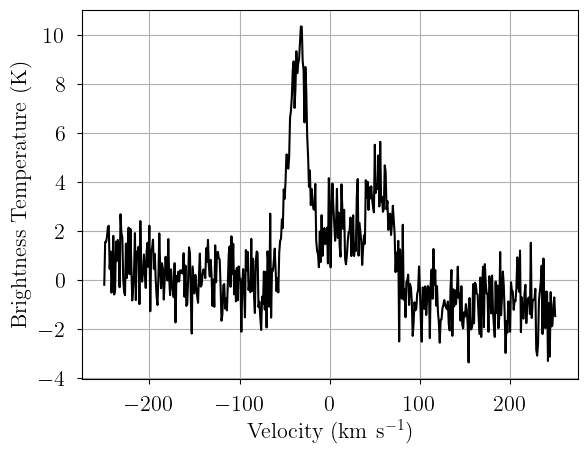

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's try the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 4,
    cores = 4,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Output()

Adding log-likelihood to trace


In [7]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [1 2 0]
Chain 2 order: [2 0 1]
Chain 3 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

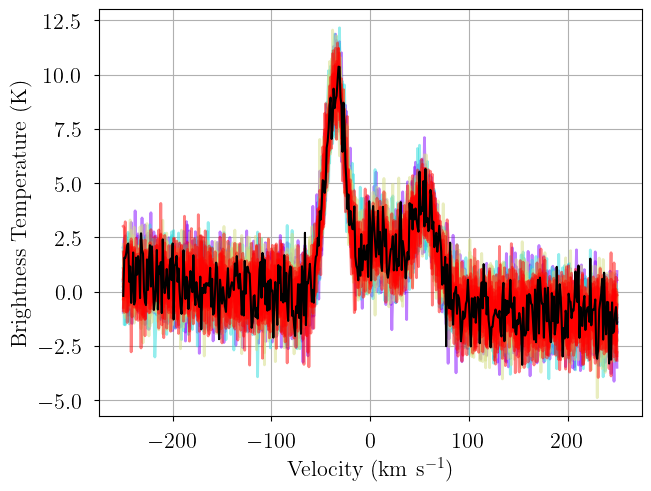

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

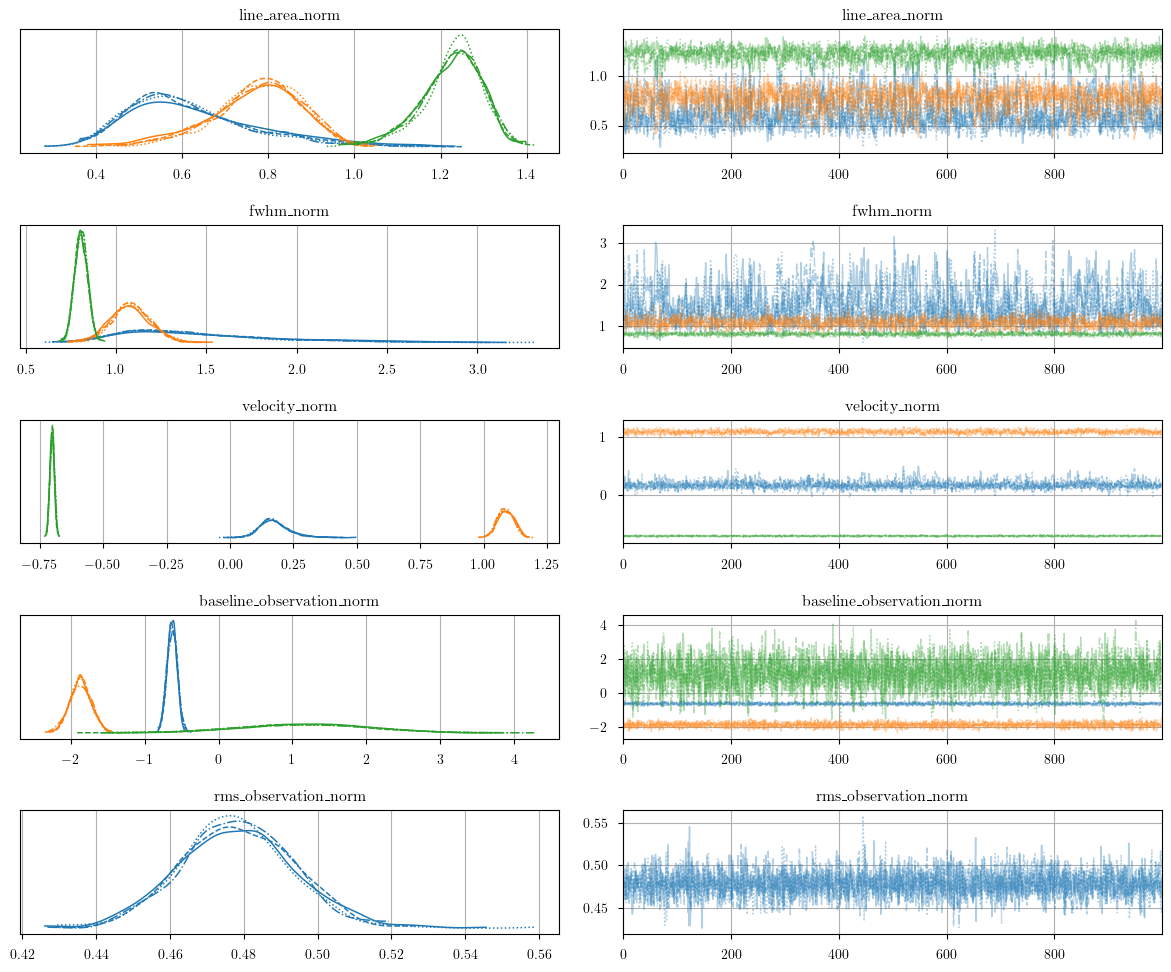

In [9]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.627   0.068   -0.757   -0.505      0.001   
baseline_observation_norm[1]   -1.868   0.142   -2.134   -1.598      0.002   
baseline_observation_norm[2]    1.158   0.873   -0.338    2.913      0.014   
velocity_norm[0]                0.176   0.062    0.070    0.302      0.002   
velocity_norm[1]                1.087   0.032    1.032    1.149      0.001   
velocity_norm[2]               -0.701   0.009   -0.717   -0.685      0.000   
line_area_norm[0]               0.627   0.155    0.371    0.924      0.006   
line_area_norm[1]               0.772   0.107    0.559    0.956      0.004   
line_area_norm[2]               1.226   0.071    1.081    1.348      0.002   
fwhm_norm[0]                    1.448   0.426    0.789    2.273      0.016   
fwhm_norm[1]                    1.082   0.109    0.891    1.298      0.003   
fwhm_norm[2]                    0.807   0.036    0.743    0.877      0.001   
rms_observation_norm            0.478   0.015    0.449    0.505      0.000   
line_area[0]                  125.338  31.014   74.200  184.761      1.179   
line_area[1]                  154.485  21.331  111.886  191.201      0.776   
line_area[2]                  245.127  14.268  216.166  269.566      0.485   
fwhm[0]                        43.451  12.781   23.675   68.193      0.481   
fwhm[1]                        32.460   3.268   26.735   38.951      0.103   
fwhm[2]                        24.202   1.086   22.277   26.314      0.029   
velocity[0]                     8.802   3.097    3.498   15.081      0.078   
velocity[1]                    54.343   1.578   51.601   57.450      0.051   
velocity[2]                   -35.032   0.441  -35.871  -34.232      0.010   
amplitude[0]                    2.752   0.256    2.281    3.230      0.006   
amplitude[1]                    4.463   0.361    3.764    5.144      0.011   
amplitude[2]                    9.515   0.355    8.859   10.202      0.009   
rms_observation                 0.956   0.030    0.897    1.010      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.001    3178.0    2970.0    1.0  
baseline_observation_norm[1]    0.002    4849.0    2825.0    1.0  
baseline_observation_norm[2]    0.014    3722.0    2666.0    1.0  
velocity_norm[0]                0.002    1820.0    1609.0    1.0  
velocity_norm[1]                0.000     967.0    2536.0    1.0  
velocity_norm[2]                0.000    1883.0    2649.0    1.0  
line_area_norm[0]               0.004     776.0    1282.0    1.0  
line_area_norm[1]               0.003     821.0    1109.0    1.0  
line_area_norm[2]               0.001     913.0    1566.0    1.0  
fwhm_norm[0]                    0.011     791.0    1535.0    1.0  
fwhm_norm[1]                    0.002     986.0    1576.0    1.0  
fwhm_norm[2]                    0.001    1424.0    1942.0    1.0  
rms_observation_norm            0.000    3843.0    2417.0    1.0  
line_area[0]                    0.800     776.0    1282.0    1.0  
line_area[1]                    0.528     821.0    1109.0    1.0  
line_area[2]                    0.292     913.0    1566.0    1.0  
fwhm[0]                         0.316     791.0    1535.0    1.0  
fwhm[1]                         0.055     986.0    1576.0    1.0  
fwhm[2]                         0.018    1424.0    1942.0    1.0  
velocity[0]                     0.084    1820.0    1609.0    1.0  
velocity[1]                     0.019     967.0    2536.0    1.0  
velocity[2]                     0.006    1883.0    2649.0    1.0  
amplitude[0]                    0.003    2108.0    2806.0    1.0  
amplitude[1]                    0.010    1320.0    1206.0    1.0  
amplitude[2]                    0.007    1602.0    1540.0    1.0  
rms_observation                 0.001    3843.0    2417.0    1.0

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference).

In [11]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Output()

Adding log-likelihood to trace


After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [12]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [2 1 0]
Chain 2 order: [2 1 0]
Chain 3 order: [2 1 0]
Chain 4 order: [1 0 2]
Chain 5 order: [0 1 2]
Adopting (first) most common order: [2 1 0]


Sampling: [observation]


Output()

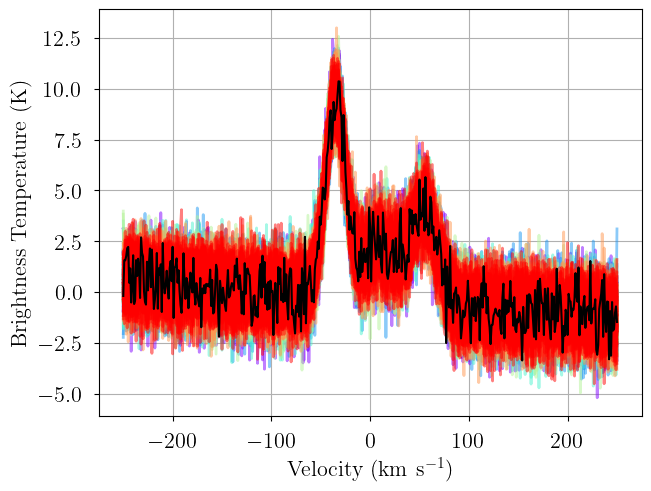

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

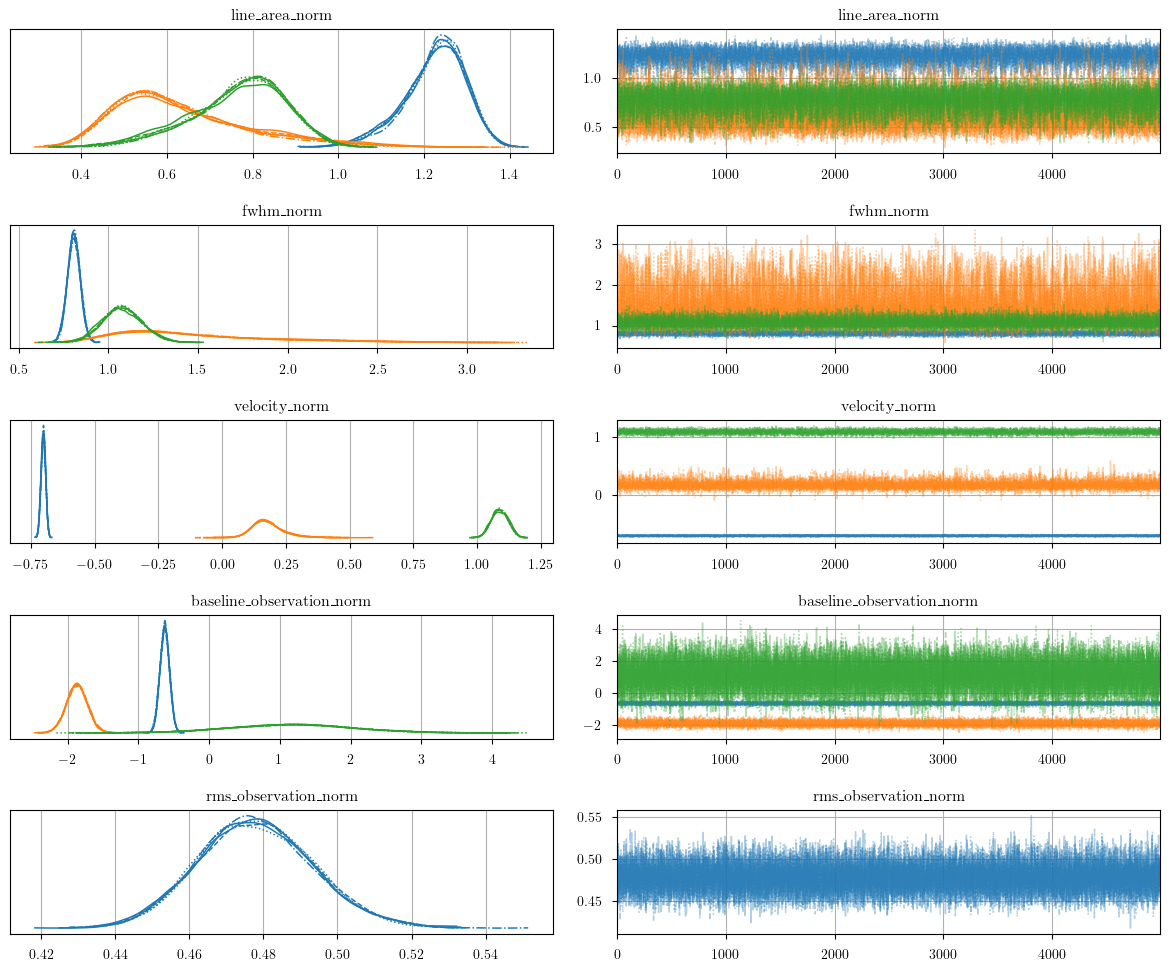

In [14]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [15]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.629   0.067   -0.755   -0.504      0.000   
baseline_observation_norm[1]   -1.870   0.147   -2.162   -1.609      0.001   
baseline_observation_norm[2]    1.159   0.855   -0.492    2.732      0.006   
line_area_norm_log__[0]         0.011   0.303   -0.605    0.318      0.112   
line_area_norm_log__[1]        -0.454   0.237   -0.878   -0.029      0.027   
line_area_norm_log__[2]        -0.116   0.259   -0.517    0.299      0.091   
fwhm_norm_log__[0]             -0.071   0.257   -0.340    0.473      0.091   
fwhm_norm_log__[1]              0.294   0.278   -0.133    0.868      0.041   
fwhm_norm_log__[2]             -0.025   0.162   -0.289    0.229      0.056   
velocity_norm[0]               -0.701   0.009   -0.717   -0.684      0.000   
velocity_norm[1]                0.178   0.064    0.070    0.309      0.001   
velocity_norm[2]                1.088   0.032    1.028    1.146      0.000   
rms_observation_norm_log__     -0.739   0.032   -0.799   -0.678      0.000   
line_area_norm[0]               1.224   0.072    1.081    1.350      0.001   
line_area_norm[1]               0.635   0.159    0.387    0.954      0.002   
line_area_norm[2]               0.767   0.111    0.550    0.960      0.002   
fwhm_norm[0]                    0.807   0.036    0.739    0.875      0.000   
fwhm_norm[1]                    1.470   0.435    0.811    2.330      0.006   
fwhm_norm[2]                    1.078   0.111    0.869    1.286      0.001   
rms_observation_norm            0.478   0.015    0.449    0.507      0.000   
line_area[0]                  244.828  14.416  216.202  270.081      0.181   
line_area[1]                  127.001  31.894   77.479  190.701      0.464   
line_area[2]                  153.447  22.161  109.979  192.034      0.321   
fwhm[0]                        24.196   1.077   22.184   26.255      0.010   
fwhm[1]                        44.102  13.063   24.318   69.903      0.192   
fwhm[2]                        32.336   3.334   26.069   38.578      0.039   
velocity[0]                   -35.046   0.440  -35.864  -34.218      0.004   
velocity[1]                     8.925   3.197    3.479   15.442      0.036   
velocity[2]                    54.402   1.597   51.385   57.299      0.020   
amplitude[0]                    9.505   0.360    8.786   10.151      0.004   
amplitude[1]                    2.748   0.256    2.291    3.250      0.002   
amplitude[2]                    4.448   0.374    3.693    5.088      0.005   
rms_observation                 0.956   0.031    0.899    1.015      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   22116.0   21750.0   1.00  
baseline_observation_norm[1]    0.001   37801.0   23003.0   1.00  
baseline_observation_norm[2]    0.004   24129.0   23243.0   1.00  
line_area_norm_log__[0]         0.062      10.0      29.0   1.64  
line_area_norm_log__[1]         0.002      87.0    8058.0   1.05  
line_area_norm_log__[2]         0.019      10.0      64.0   1.61  
fwhm_norm_log__[0]              0.073      10.0      25.0   1.64  
fwhm_norm_log__[1]              0.002      44.0    6907.0   1.09  
fwhm_norm_log__[2]              0.011      10.0      75.0   1.56  
velocity_norm[0]                0.000   12619.0   18848.0   1.00  
velocity_norm[1]                0.001    9382.0    7424.0   1.00  
velocity_norm[2]                0.000    6694.0   12691.0   1.00  
rms_observation_norm_log__      0.000   38080.0   22496.0   1.00  
line_area_norm[0]               0.001    6927.0    8876.0   1.00  
line_area_norm[1]               0.002    5367.0    7593.0   1.00  
line_area_norm[2]               0.001    5169.0    6873.0   1.00  
fwhm_norm[0]                    0.000   10773.0   12430.0   1.00  
fwhm_norm[1]                    0.004    5366.0    8361.0   1.00  
fwhm_norm[2]                    0.001    7214.0    9619.0   1.00  
rms_observation_norm            0.000   

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [16]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [17]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Output()

Adding log-likelihood to trace


In [18]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [2 1 0]
Chain 2 order: [2 0 1]
Chain 3 order: [2 0 1]
Chain 4 order: [1 2 0]
Chain 5 order: [0 1 2]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

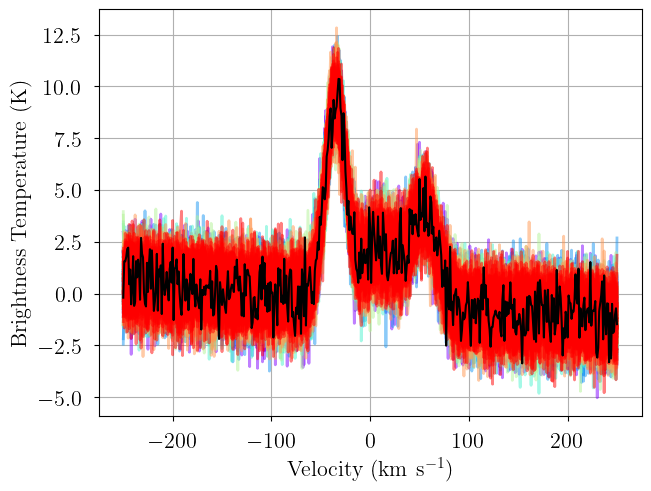

In [19]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

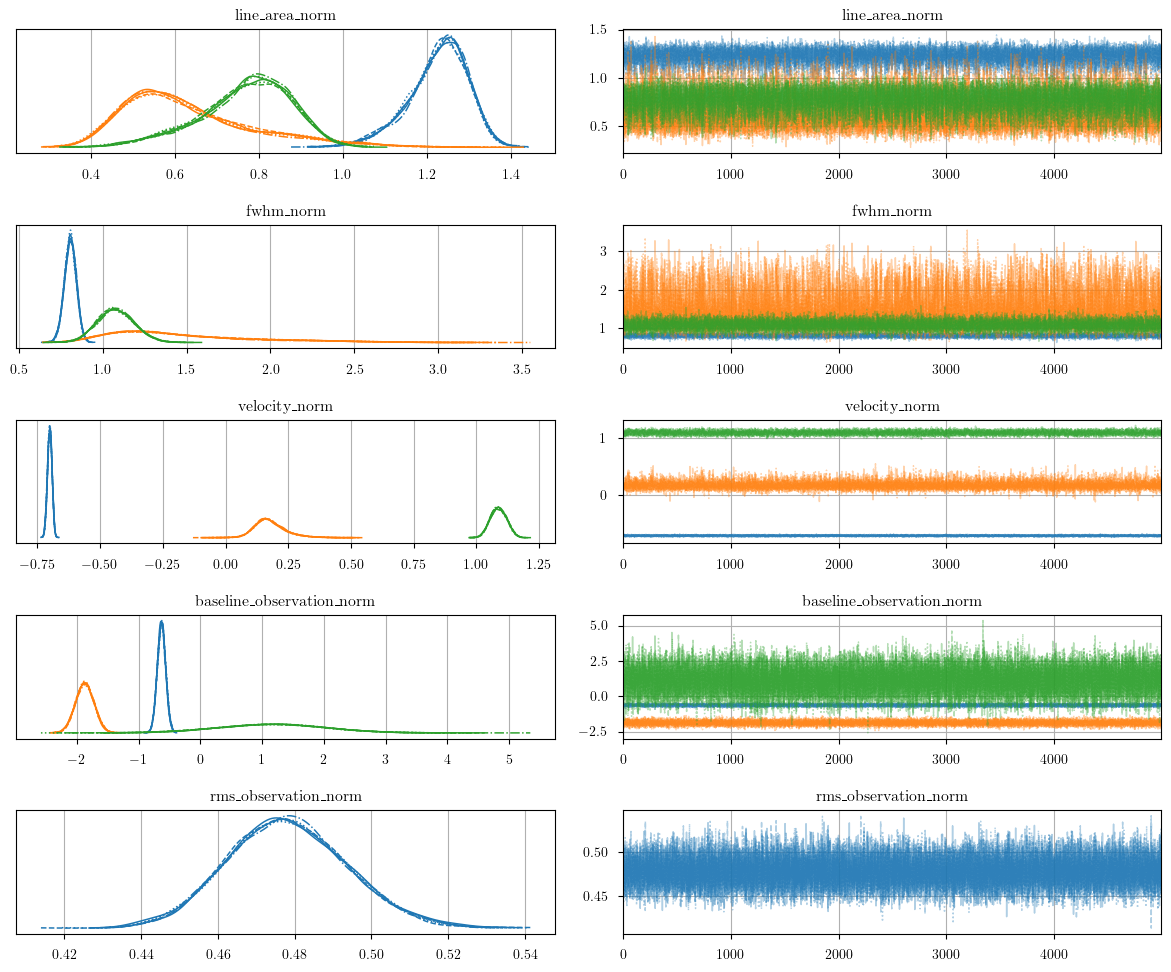

In [20]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [21]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.628   0.068   -0.757   -0.501      0.001   
baseline_observation_norm[1]   -1.871   0.148   -2.149   -1.595      0.001   
baseline_observation_norm[2]    1.150   0.864   -0.502    2.736      0.006   
velocity_norm[0]               -0.701   0.009   -0.718   -0.684      0.000   
velocity_norm[1]                0.178   0.064    0.065    0.303      0.001   
velocity_norm[2]                1.088   0.032    1.030    1.149      0.000   
line_area_norm[0]               1.225   0.072    1.086    1.352      0.001   
line_area_norm[1]               0.633   0.159    0.392    0.956      0.002   
line_area_norm[2]               0.768   0.110    0.547    0.957      0.001   
fwhm_norm[0]                    0.807   0.036    0.740    0.875      0.000   
fwhm_norm[1]                    1.464   0.435    0.828    2.344      0.006   
fwhm_norm[2]                    1.078   0.111    0.869    1.283      0.001   
rms_observation_norm            0.478   0.016    0.449    0.507      0.000   
line_area[0]                  244.948  14.366  217.104  270.481      0.173   
line_area[1]                  126.505  31.793   78.439  191.226      0.429   
line_area[2]                  153.631  22.006  109.403  191.475      0.283   
fwhm[0]                        24.201   1.072   22.200   26.237      0.010   
fwhm[1]                        43.933  13.042   24.849   70.308      0.177   
fwhm[2]                        32.352   3.326   26.072   38.503      0.036   
velocity[0]                   -35.042   0.447  -35.889  -34.222      0.004   
velocity[1]                     8.908   3.198    3.264   15.139      0.033   
velocity[2]                    54.391   1.598   51.506   57.442      0.018   
amplitude[0]                    9.508   0.360    8.807   10.162      0.003   
amplitude[1]                    2.748   0.258    2.276    3.240      0.002   
amplitude[2]                    4.452   0.374    3.713    5.120      0.004   
rms_observation                 0.956   0.031    0.897    1.014      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   18040.0   19750.0    1.0  
baseline_observation_norm[1]    0.001   28735.0   20714.0    1.0  
baseline_observation_norm[2]    0.005   18460.0   20133.0    1.0  
velocity_norm[0]                0.000   11534.0   19085.0    1.0  
velocity_norm[1]                0.001   11019.0   10033.0    1.0  
velocity_norm[2]                0.000    7791.0   14651.0    1.0  
line_area_norm[0]               0.001    7533.0    9193.0    1.0  
line_area_norm[1]               0.001    6025.0    9749.0    1.0  
line_area_norm[2]               0.001    6436.0    8771.0    1.0  
fwhm_norm[0]                    0.000   10591.0   12458.0    1.0  
fwhm_norm[1]                    0.004    5969.0   10175.0    1.0  
fwhm_norm[2]                    0.001    8327.0   12805.0    1.0  
rms_observation_norm            0.000   25270.0   20413.0    1.0  
line_area[0]                    0.124    7533.0    9193.0    1.0  
line_area[1]                    0.297    6025.0    9749.0    1.0  
line_area[2]                    0.182    6436.0    8771.0    1.0  
fwhm[0]                         0.007   10591.0   12458.0    1.0  
fwhm[1]                         0.115    5969.0   10175.0    1.0  
fwhm[2]                         0.020    8327.0   12805.0    1.0  
velocity[0]                     0.002   11534.0   19085.0    1.0  
velocity[1]                     0.034   11019.0   10033.0    1.0  
velocity[2]                     0.008    7791.0   14651.0    1.0  
amplitude[0]                    0.002   13124.0   12912.0    1.0  
amplitude[1]                    0.001   14611.0   21572.0    1.0  
amplitude[2]                    0.003    9715.0   10323.0    1.0  
rms_observation                 0.000   25270.0   20413.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [22]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

Running window adaptation


Adding log-likelihood to trace


Output()

In [23]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [0 1 2]
Chain 2 order: [0 1 2]
Chain 3 order: [0 2 1]
Chain 4 order: [1 0 2]
Chain 5 order: [1 2 0]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

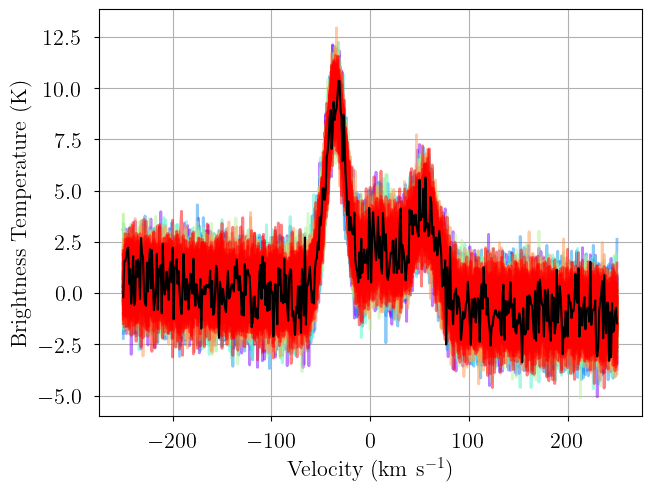

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

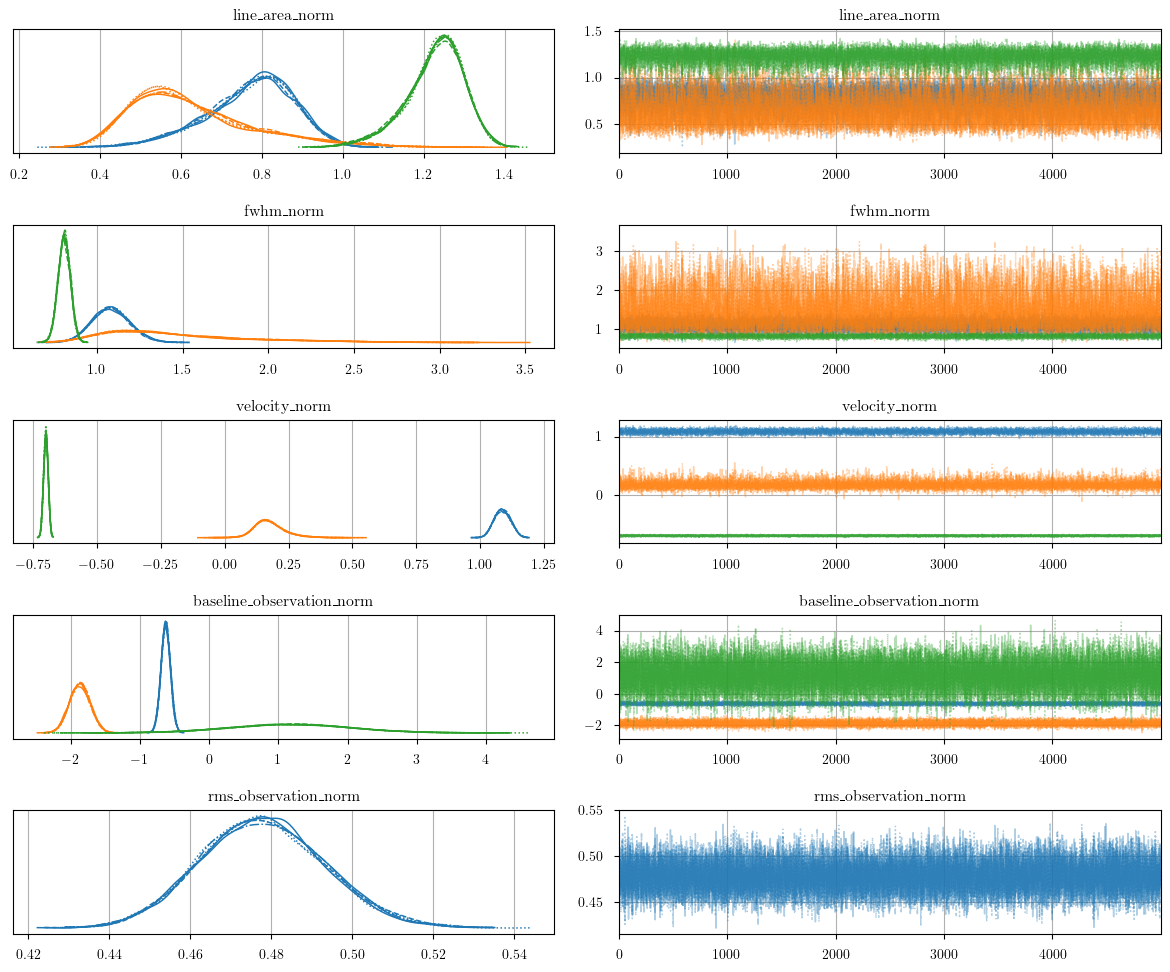

In [25]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [26]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.629   0.068   -0.760   -0.504      0.001   
baseline_observation_norm[1]   -1.872   0.148   -2.142   -1.589      0.001   
baseline_observation_norm[2]    1.168   0.863   -0.403    2.846      0.006   
velocity_norm[0]                1.087   0.032    1.030    1.147      0.000   
velocity_norm[1]                0.177   0.062    0.071    0.304      0.001   
velocity_norm[2]               -0.701   0.009   -0.718   -0.685      0.000   
line_area_norm[0]               0.771   0.108    0.561    0.967      0.001   
line_area_norm[1]               0.628   0.155    0.387    0.937      0.002   
line_area_norm[2]               1.227   0.072    1.085    1.353      0.001   
fwhm_norm[0]                    1.081   0.110    0.876    1.287      0.001   
fwhm_norm[1]                    1.451   0.426    0.814    2.310      0.006   
fwhm_norm[2]                    0.807   0.036    0.740    0.873      0.000   
rms_observation_norm            0.478   0.015    0.449    0.506      0.000   
line_area[0]                  154.295  21.685  112.276  193.375      0.281   
line_area[1]                  125.653  31.061   77.317  187.495      0.425   
line_area[2]                  245.391  14.302  216.915  270.584      0.172   
fwhm[0]                        32.430   3.297   26.272   38.621      0.037   
fwhm[1]                        43.540  12.794   24.418   69.287      0.176   
fwhm[2]                        24.220   1.069   22.186   26.194      0.010   
velocity[0]                    54.352   1.584   51.479   57.337      0.018   
velocity[1]                     8.838   3.116    3.543   15.177      0.031   
velocity[2]                   -35.038   0.439  -35.878  -34.231      0.004   
amplitude[0]                    4.461   0.367    3.749    5.119      0.004   
amplitude[1]                    2.754   0.258    2.289    3.251      0.002   
amplitude[2]                    9.518   0.357    8.823   10.186      0.003   
rms_observation                 0.956   0.031    0.897    1.013      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   17714.0   20120.0    1.0  
baseline_observation_norm[1]    0.001   25917.0   22351.0    1.0  
baseline_observation_norm[2]    0.005   18179.0   20868.0    1.0  
velocity_norm[0]                0.000    7688.0   14639.0    1.0  
velocity_norm[1]                0.001   11078.0   10335.0    1.0  
velocity_norm[2]                0.000   12865.0   17812.0    1.0  
line_area_norm[0]               0.001    6372.0    8805.0    1.0  
line_area_norm[1]               0.002    5879.0    9149.0    1.0  
line_area_norm[2]               0.001    7644.0    8913.0    1.0  
fwhm_norm[0]                    0.001    7675.0   11534.0    1.0  
fwhm_norm[1]                    0.004    5859.0    9769.0    1.0  
fwhm_norm[2]                    0.000   10481.0   12974.0    1.0  
rms_observation_norm            0.000   26621.0   21045.0    1.0  
line_area[0]                    0.179    6372.0    8805.0    1.0  
line_area[1]                    0.303    5879.0    9149.0    1.0  
line_area[2]                    0.126    7644.0    8913.0    1.0  
fwhm[0]                         0.019    7675.0   11534.0    1.0  
fwhm[1]                         0.121    5859.0    9769.0    1.0  
fwhm[2]                         0.006   10481.0   12974.0    1.0  
velocity[0]                     0.008    7688.0   14639.0    1.0  
velocity[1]                     0.033   11078.0   10335.0    1.0  
velocity[2]                     0.002   12865.0   17812.0    1.0  
amplitude[0]                    0.003   10489.0   11031.0    1.0  
amplitude[1]                    0.001   15544.0   22050.0    1.0  
amplitude[2]                    0.002   12560.0   13893.0    1.0  
rms_observation                 0.000   26621.0   21045.0    1.0

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [27]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [28]:
model.solve()

No solution found!
0 of 8 chains appear converged.


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

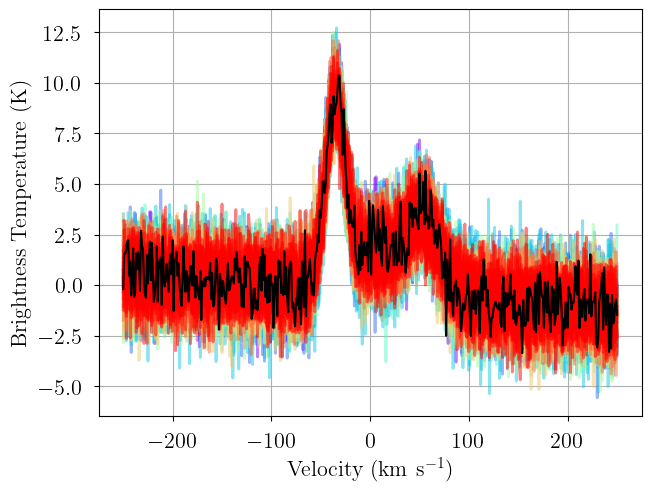

In [29]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

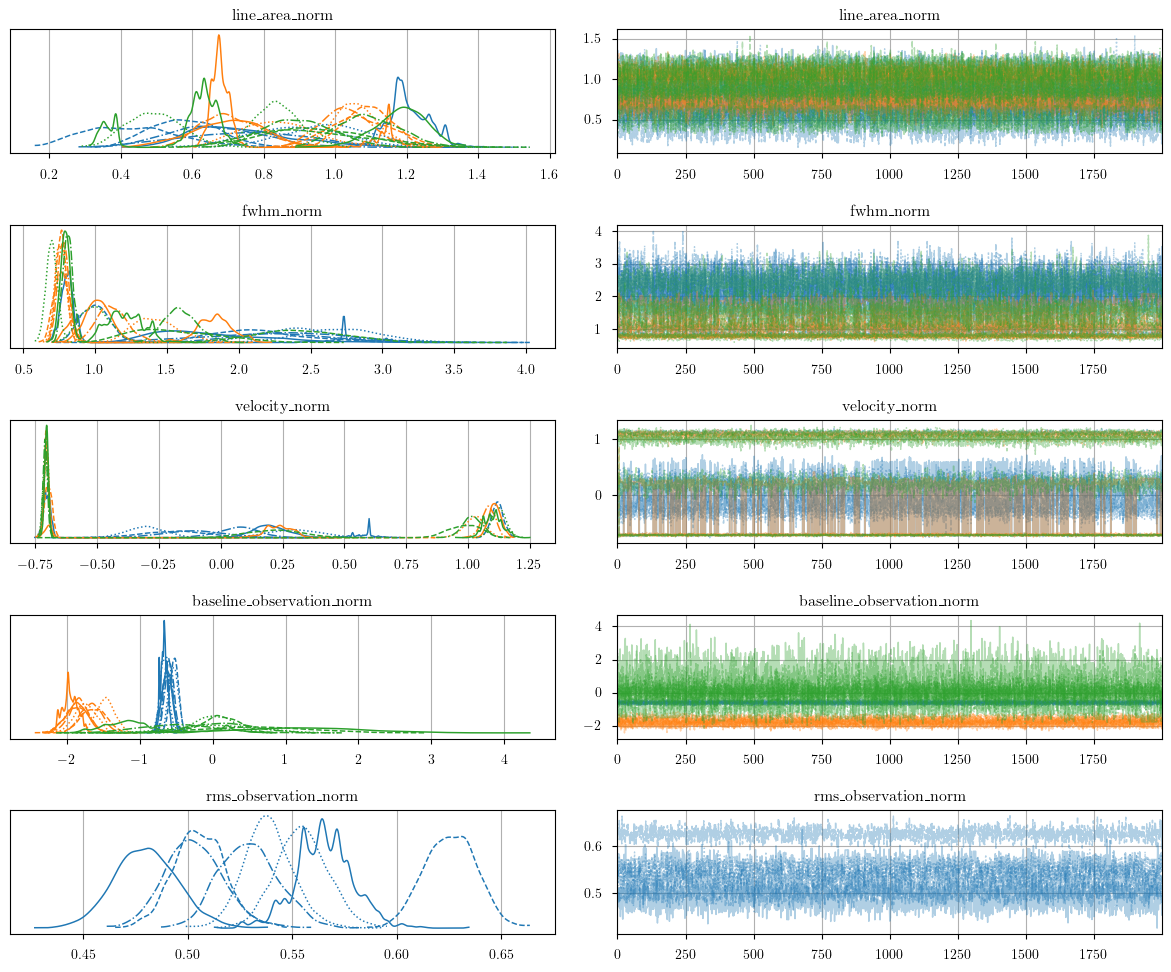

In [30]:
axes = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [31]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


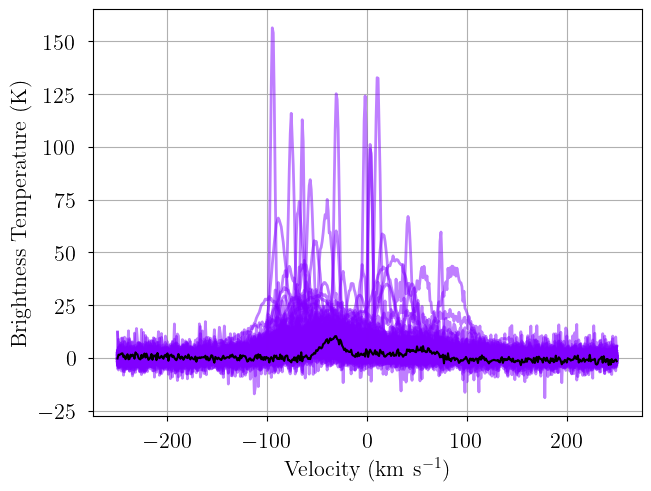

In [32]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [33]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [34]:
model.solve()

GMM converged to unique solution


Sampling: [observation]


Output()

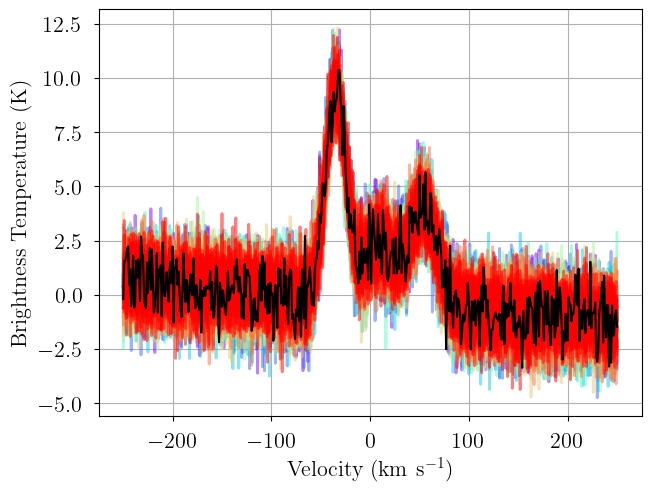

In [35]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

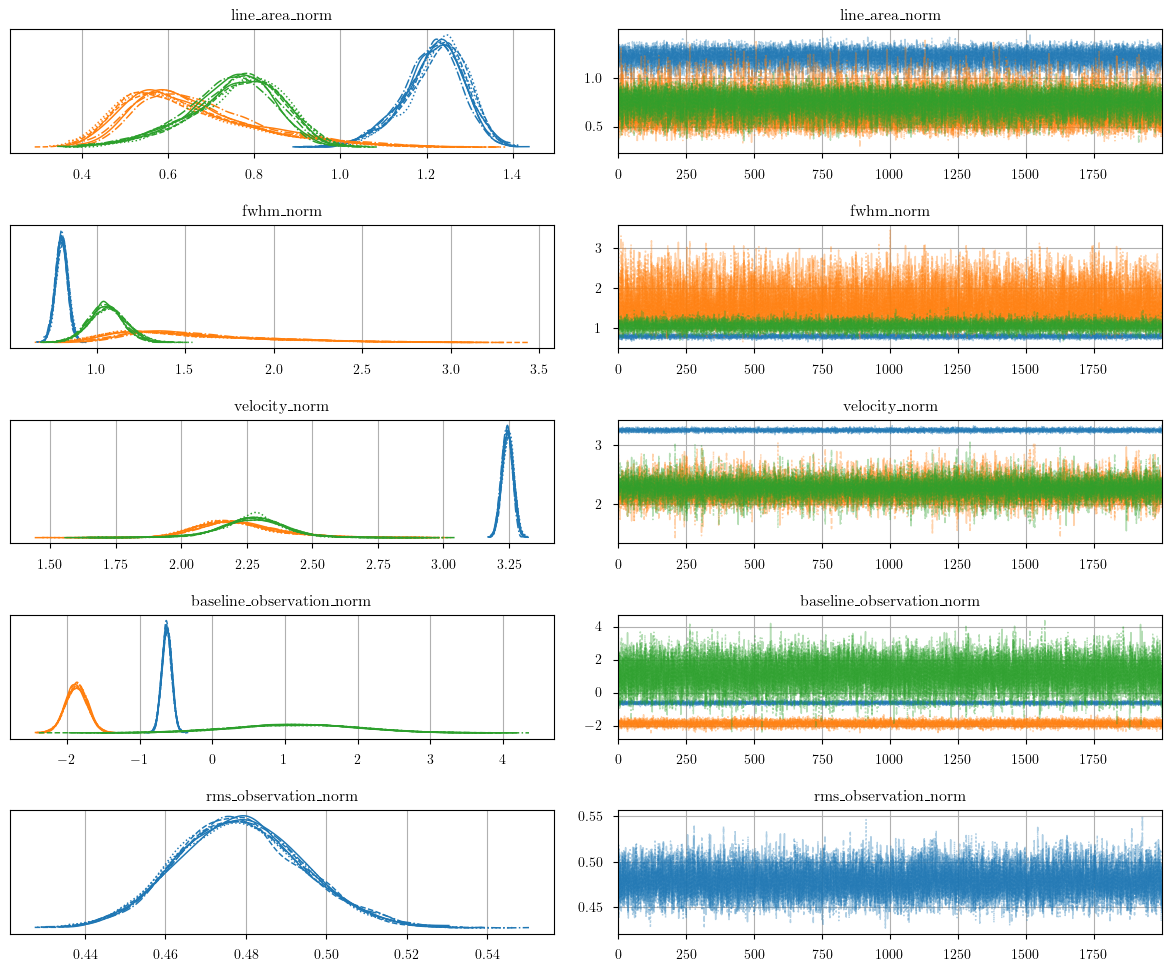

In [36]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [37]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.627   0.067   -0.754   -0.502      0.001   
baseline_observation_norm[1]   -1.870   0.148   -2.147   -1.590      0.001   
baseline_observation_norm[2]    1.148   0.857   -0.454    2.745      0.007   
line_area_norm[0]               1.217   0.072    1.070    1.340      0.001   
line_area_norm[1]               0.656   0.155    0.416    0.966      0.001   
line_area_norm[2]               0.752   0.107    0.540    0.939      0.001   
fwhm_norm[0]                    0.803   0.035    0.739    0.872      0.000   
fwhm_norm[1]                    1.536   0.423    0.897    2.365      0.005   
fwhm_norm[2]                    1.061   0.103    0.872    1.262      0.001   
velocity_norm[0]                3.245   0.021    3.204    3.284      0.000   
velocity_norm[1]                2.215   0.164    1.932    2.541      0.001   
velocity_norm[2]                2.272   0.135    2.008    2.528      0.001   
rms_observation_norm            0.479   0.016    0.451    0.509      0.000   
line_area[0]                  243.482  14.383  214.003  267.953      0.116   
line_area[1]                  131.283  31.013   83.213  193.218      0.272   
line_area[2]                  150.430  21.433  107.946  187.802      0.218   
fwhm[0]                        24.103   1.045   22.175   26.159      0.009   
fwhm[1]                        46.074  12.683   26.917   70.940      0.145   
fwhm[2]                        31.821   3.083   26.151   37.861      0.031   
velocity[0]                   -35.100   0.426  -35.917  -34.325      0.004   
velocity[1]                     9.207   3.278    3.499   15.733      0.028   
velocity[2]                    54.644   1.493   51.858   57.421      0.037   
amplitude[0]                    9.489   0.371    8.799   10.189      0.003   
amplitude[1]                    2.712   0.244    2.243    3.157      0.003   
amplitude[2]                    4.431   0.386    3.651    5.095      0.003   
rms_observation                 0.957   0.031    0.901    1.018      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   15753.0   15647.0   1.00  
baseline_observation_norm[1]    0.001   15469.0   15799.0   1.00  
baseline_observation_norm[2]    0.005   15232.0   15663.0   1.00  
line_area_norm[0]               0.000   15217.0   15517.0   1.01  
line_area_norm[1]               0.001    1676.0   10671.0   1.01  
line_area_norm[2]               0.001    7609.0   13488.0   1.01  
fwhm_norm[0]                    0.000   14054.0   15240.0   1.00  
fwhm_norm[1]                    0.003     700.0    1645.0   1.01  
fwhm_norm[2]                    0.001   10256.0   14276.0   1.01  
velocity_norm[0]                0.000   10372.0   14734.0   1.01  
velocity_norm[1]                0.001   13767.0   14388.0   1.00  
velocity_norm[2]                0.001   14878.0   14464.0   1.00  
rms_observation_norm            0.000   15236.0   14492.0   1.00  
line_area[0]                    0.089   15217.0   15517.0   1.01  
line_area[1]                    0.207    1676.0   10671.0   1.01  
line_area[2]                    0.133    7609.0   13488.0   1.01  
fwhm[0]                         0.006   14054.0   15240.0   1.00  
fwhm[1]                         0.080     700.0    1645.0   1.01  
fwhm[2]                         0.019   10256.0   14276.0   1.01  
velocity[0]                     0.002   10372.0   14734.0   1.01  
velocity[1]                     0.028   14187.0   14747.0   1.00  
velocity[2]                     0.008    1619.0   13404.0   1.01  
amplitude[0]                    0.002   15938.0   15343.0   1.00  
amplitude[1]                    0.001    9619.0   15253.0   1.01  
amplitude[2]                    0.003   14571.0   14143.0   1.00  
rms_observation                 0.000   15236.0   14492.0   1.00